In [1]:
import os
import pandas as pd
import numpy as np
import gower
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

import matplotlib.style
import matplotlib as mpl

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# load data
DATA_PATH = os.path.join(os.getcwd(),'../Earthquake')
raw = pd.read_csv(os.path.join(DATA_PATH,'bank_marketing.csv'),low_memory=False,)

# convert numerical-object to numericals
#for col in ['time','latitude','longitude','depth', 'mag','magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontal', 'depthError', 'magNst', 'status', 'locationSource', 'magSource']:
#    raw[col] = raw[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)

# clean textual classes
#for col in raw.select_dtypes(include='object').columns:
#        raw[col] = raw[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(raw.columns,raw.dtypes)}

raw[:5]

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,0,41,services,married,unknown,no,88,yes,no,cellular,11,may,105,1,336,2,failure,no
1,1,56,technician,married,secondary,no,1938,no,yes,cellular,26,feb,229,1,192,4,success,yes
2,2,30,services,single,secondary,no,245,no,yes,cellular,8,jul,187,2,-1,0,unknown,no
3,3,34,management,single,tertiary,no,1396,yes,no,cellular,17,jul,630,1,-1,0,unknown,no
4,4,29,technician,single,secondary,no,-13,yes,no,cellular,14,may,512,3,-1,0,unknown,no


In [3]:
# copy df
df = raw.copy()

# drop ID and Birth
df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

# remove all nan values
for col in ['age','balance','day', 'duration', 'pdays']:
    df[col].fillna(df[col].mean(),inplace=True)
if df.isnull().sum().sum() == 0: print('No NaNs')
    
df["loan"].replace({"yes":1, "no":0}, inplace = True)
df["housing"].replace({"yes":1, "no":0}, inplace = True)
df["deposit"].replace({"no":0, "yes":1}, inplace = True)
df["default"].replace({"yes":1, "no":0}, inplace = True)


data_meta = pd.DataFrame(df.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'

# exclude known numericals
data_meta.loc[(data_meta['num']<=500) & (~data_meta['name'].isin(['loan','deposit','housing', 'default','pdays','age','day', 'duration', 'campaign'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['loan', 'housing', 'deposit']),'type']='claim'

categorical_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
numerical_features = list(data_meta.loc[data_meta['type']=='numerical','name'])

df['job'] = df['job'].map({'admin.':'Ad',         
'blue-collar':'Blu',    
'entrepreneur':'Ent' ,   
'housemaid' : 'HM' ,      
'management' : 'Mg',     
'retired' : 'Rtd',        
'self-employed' : 'Slf',   
'services' : 'Sv',       
'student' : 'St',        
'technician' : 'Tec',     
'unemployed' : 'Uem',     
'unknown' : 'Un'})


No NaNs


In [4]:
data_meta

,name,num,type
0,deposit,2,claim
1,loan,2,claim
2,housing,2,claim
3,default,2,numerical
4,contact,3,categorical
5,marital,3,categorical
6,poutcome,4,categorical
7,education,4,categorical
8,job,12,categorical
9,month,12,categorical


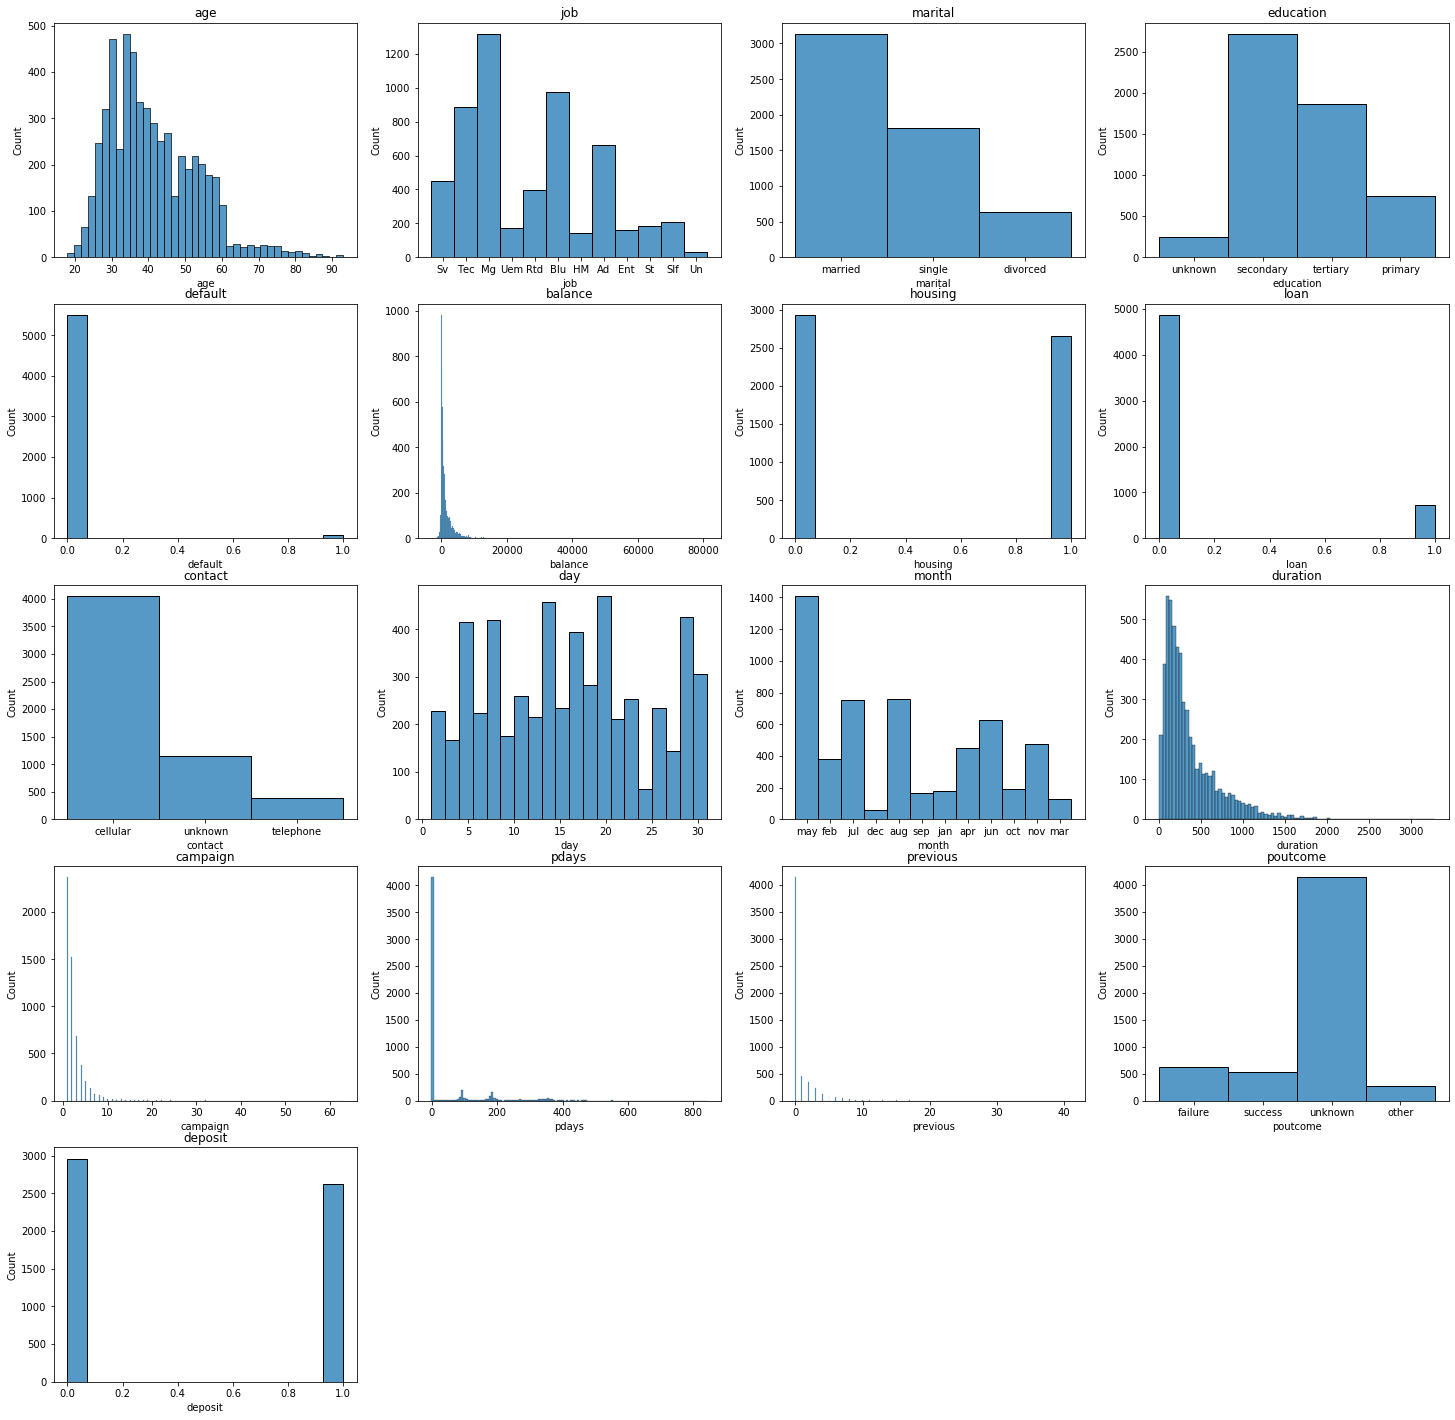

In [5]:
fig = plt.figure(figsize=(25, 25))
for i, col in enumerate(df.columns):
    ax = plt.subplot2grid((5, 4),(i//4, i%4))
    sns.histplot(df[col], ax=ax)
    ax.set_title(col)

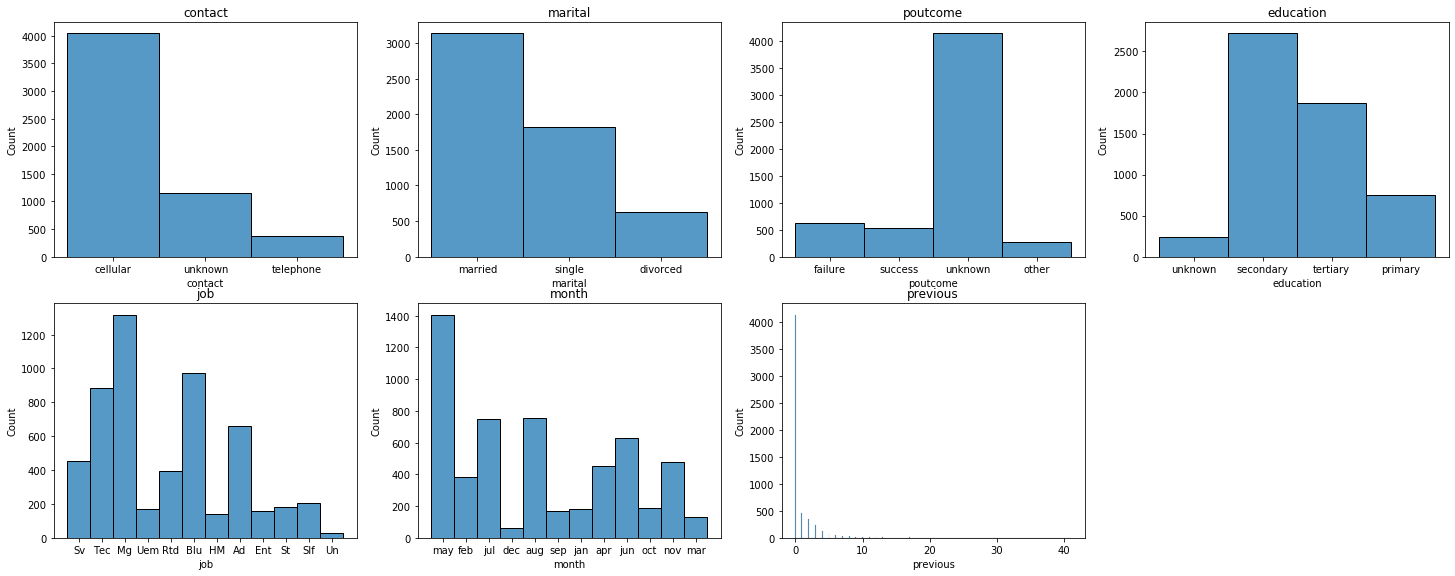

In [6]:
fig = plt.figure(figsize=(25, 25))
for i, col in enumerate(categorical_features):
    ax = plt.subplot2grid((5, 4),(i//4, i%4))
    sns.histplot(df[col], ax=ax)
    ax.set_title(col)

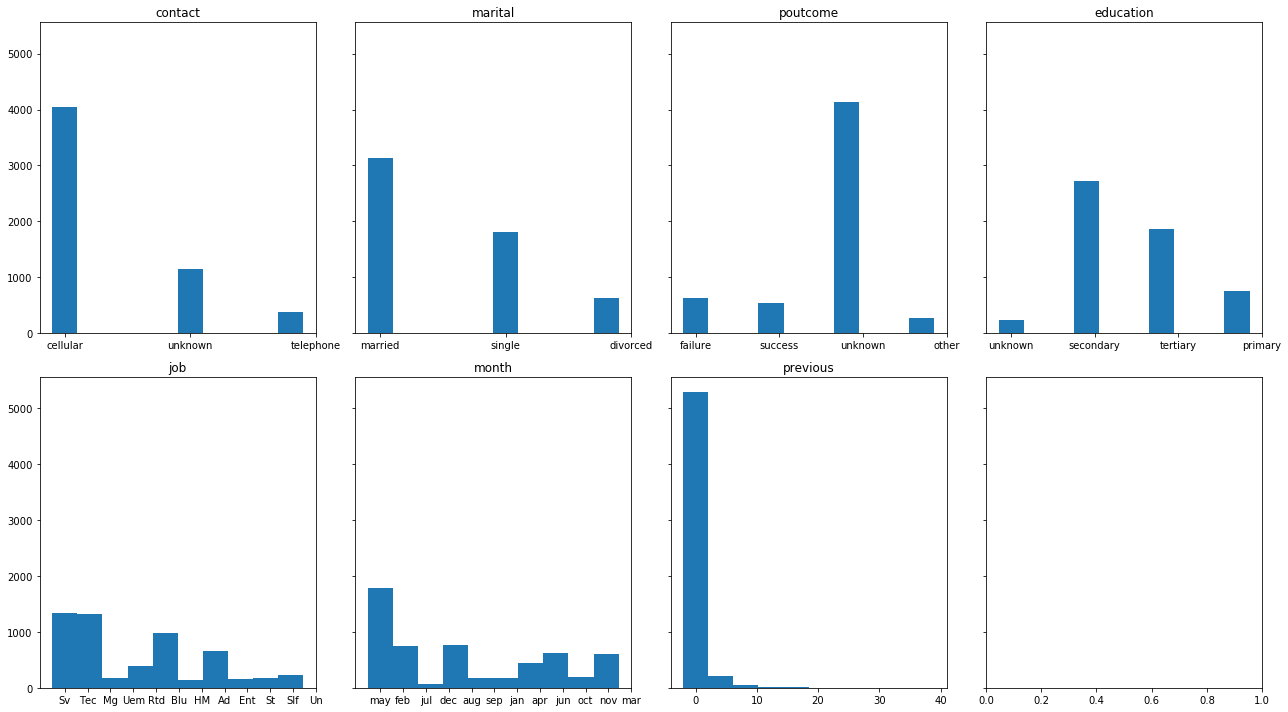

In [7]:
fig,axs = plt.subplots(2,4,figsize=(18,10),sharey=True)

for ax,feat in zip(axs.flatten(),categorical_features):
    ax.hist(df[feat],align='left')
    ax.set_title(feat)
plt.tight_layout()

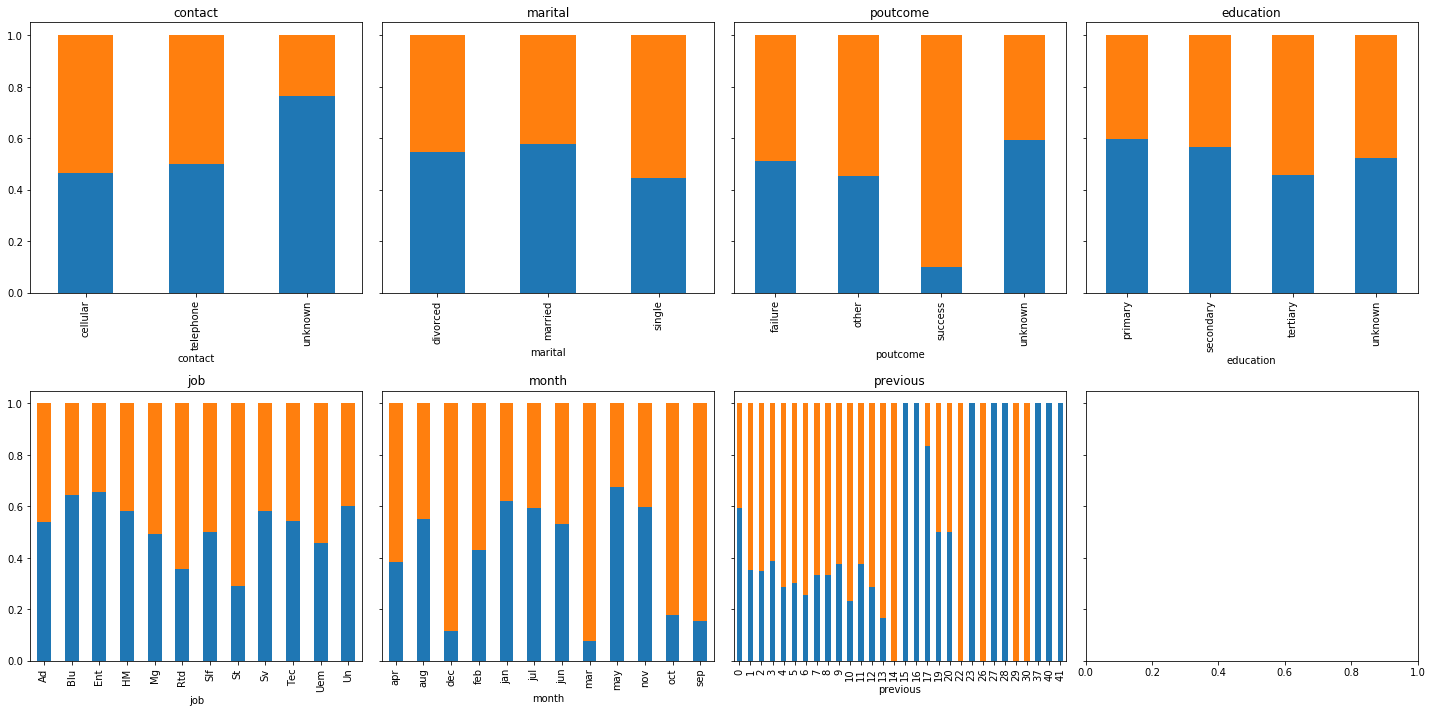

In [8]:
fig,axs = plt.subplots(2,4,figsize=(20,10),sharey=True)

for ax,feat in zip(axs.flatten(),categorical_features):
    ((pd.crosstab(df['deposit'],df[feat])) / (pd.crosstab(df['deposit'],df[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
plt.tight_layout()

In [9]:
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler


In [10]:
df[numerical_features][:2]

,default,day,campaign,age,pdays,duration,balance
0,0,11,1,41,336,105,88
1,0,26,1,56,192,229,1938


In [11]:
# Standard Scaled "mean normalisation"
scaler = StandardScaler()
scaler.fit(df[numerical_features])
print("Feature Means:\t",[f"{x:.2}" for x in scaler.mean_])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

Feature Means:	 ['0.015', '1.6e+01', '2.5', '4.1e+01', '5.3e+01', '3.7e+02', '1.5e+03']


,default,day,campaign,age,pdays,duration,balance
0,-0.123617,-0.554778,-0.544109,-0.014229,2.559623,-0.764824,-0.436813
1,-0.123617,1.218203,-0.544109,1.243635,1.259340,-0.404463,0.129587


In [12]:
# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[numerical_features])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

,default,day,campaign,age,pdays,duration,balance
0,0.0,0.333333,0.0,0.306667,0.399763,0.031088,0.037336
1,0.0,0.833333,0.0,0.506667,0.228944,0.068881,0.059291


In [13]:
# or pd.cut()
df['previous']= pd.cut(df['previous'],
                       bins=[0,1,2,3,4,5,6,8,9,50],
                       labels=[0,1,2,3,4,5,6,7,8],
                       include_lowest=True,
                       right=True).astype(float)

In [14]:
# create some lists
ordinal_features = ['education','previous','day']
print("Ordinals:\n",ordinal_features)

# apply order to education
df['education'] = df['education'].map({'unknown':0, 'primary':1, 'secondary':2,'tertiary':3})
ordinal_data = df[ordinal_features]

# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[ordinal_features])
ordinal_data = scaler.transform(df[ordinal_features])
ordinal_data= pd.DataFrame(ordinal_data,index=df.index,columns=ordinal_features)
ordinal_data[:5]

Ordinals:
 ['education', 'previous', 'day']


,education,previous,day
0,0.000000,0.125,0.333333
1,0.666667,0.375,0.833333
2,0.666667,0.000,0.233333
3,1.000000,0.000,0.533333
4,0.666667,0.000,0.433333


In [15]:
# For the nominals one-hot-encoding is applied
nominal_features = [c for c in categorical_features if c not in ordinal_features]
print("Nominals:\n",nominal_features)

nominal_data = list()
for i,x in df[nominal_features].nunique().iteritems():
    if x <= 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=True))
    elif x > 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=False))
        
nominal_data = pd.concat(nominal_data,axis=1)
nominal_data[:2]

Nominals:
 ['contact', 'marital', 'poutcome', 'job', 'month']


,contact_cellular,contact_telephone,contact_unknown,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [16]:
# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_data,nominal_data,ordinal_data],axis=1)
print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

# original data
Xy_original = df[numerical_features+nominal_features+ordinal_features].copy()

Data min:max (0.0, 1.0000000000000002)


In [17]:
Xy_original

,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day
0,0,11,1,41,336,105,88,cellular,married,failure,Sv,may,0,1.0,11
1,0,26,1,56,192,229,1938,cellular,married,success,Tec,feb,2,3.0,26
2,0,8,2,30,-1,187,245,cellular,single,unknown,Sv,jul,2,0.0,8
3,0,17,1,34,-1,630,1396,cellular,single,unknown,Mg,jul,3,0.0,17
4,0,14,3,29,-1,512,-13,cellular,single,unknown,Tec,may,2,0.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5576,0,15,2,48,-1,755,2235,unknown,married,unknown,Ad,may,2,0.0,15
5577,0,4,3,40,340,195,-388,cellular,married,failure,Blu,may,1,0.0,4
5578,0,4,6,27,95,157,91,telephone,single,other,St,dec,2,8.0,4
5579,0,2,1,46,55,310,1568,cellular,married,other,Blu,jun,2,5.0,2


In [18]:
for i,col in enumerate(Xy_scaled.columns):
    Xy_scaled[col].fillna(Xy_scaled[col].mean(),inplace=True)
if Xy_scaled.isnull().sum().sum() == 0: print('No NaNs')



No NaNs


C:\Users\vikas\Anaconda3\lib\site-packages\pandas\core\generic.py:6244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [19]:
Xy_scaled

,default,day,campaign,age,pdays,duration,balance,contact_cellular,contact_telephone,contact_unknown,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,education,previous,day
0,0.0,0.333333,0.000000,0.306667,0.399763,0.031088,0.037336,1,0,0,...,0,0,0,1,0,0,0,0.000000,0.125,0.333333
1,0.0,0.833333,0.000000,0.506667,0.228944,0.068881,0.059291,1,0,0,...,0,0,0,0,0,0,0,0.666667,0.375,0.833333
2,0.0,0.233333,0.016129,0.160000,0.000000,0.056080,0.039199,1,0,0,...,1,0,0,0,0,0,0,0.666667,0.000,0.233333
3,0.0,0.533333,0.000000,0.213333,0.000000,0.191100,0.052859,1,0,0,...,1,0,0,0,0,0,0,1.000000,0.000,0.533333
4,0.0,0.433333,0.032258,0.146667,0.000000,0.155136,0.036137,1,0,0,...,0,0,0,1,0,0,0,0.666667,0.000,0.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5576,0.0,0.466667,0.016129,0.400000,0.000000,0.229198,0.062816,0,0,1,...,0,0,0,1,0,0,0,0.666667,0.000,0.466667
5577,0.0,0.100000,0.032258,0.293333,0.404508,0.058519,0.031687,1,0,0,...,0,0,0,1,0,0,0,0.333333,0.000,0.100000
5578,0.0,0.100000,0.080645,0.120000,0.113879,0.046937,0.037372,0,1,0,...,0,0,0,0,0,0,0,0.666667,1.000,0.100000
5579,0.0,0.033333,0.000000,0.373333,0.066429,0.093569,0.054900,1,0,0,...,0,1,0,0,0,0,0,0.666667,0.625,0.033333


In [20]:
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

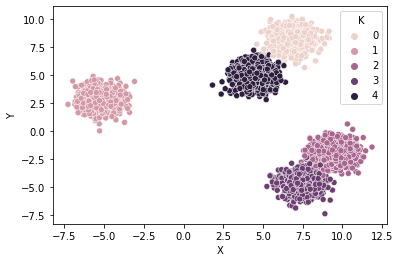

In [21]:
Xy_,clusters_ = make_blobs(n_samples=4000, centers=5, cluster_std=0.7)
df_ = pd.DataFrame(Xy_,columns=['X','Y'])
df_['K'] = clusters_
sns.scatterplot(x='X',y='Y',hue='K',data=df_);

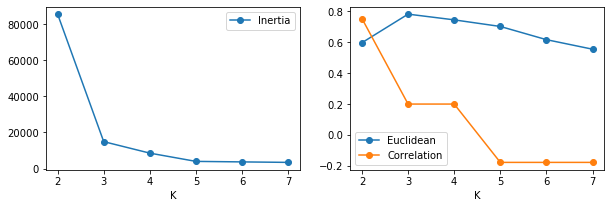

In [22]:
results = dict()
k_cand = [2,3,4,5,6,7] #

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,2,sharex=True,figsize=(10,3))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

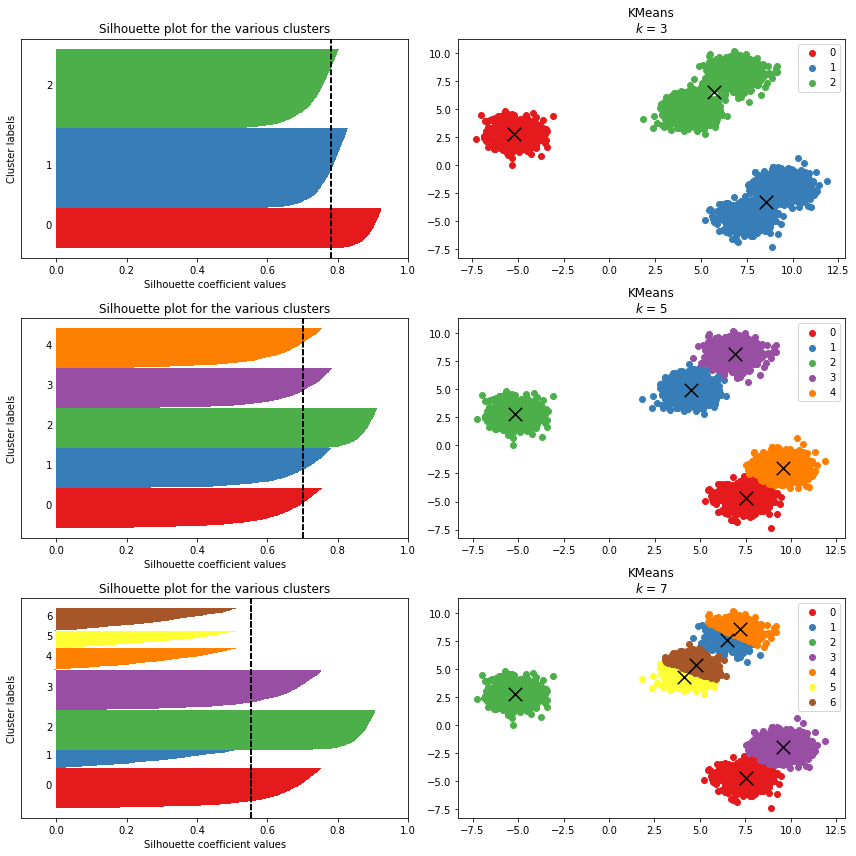

In [23]:
k_cand = [3,5,7]

fig,axs = plt.subplots(len(k_cand),2,figsize=(12,12))

for e,k in enumerate(k_cand):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    
    cdict = {i:cm.Set1(i) for i in np.unique(kmeans.labels_)}
    
    ## silhouette samples
    silhouette_vals = silhouette_samples(Xy_,kmeans.labels_)
    y_lower = 0 
    y_upper = 0
    for i,cluster in enumerate(np.unique(kmeans.labels_)):
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        axs[e,0].barh(range(y_lower,y_upper),
                      cluster_silhouette_vals,
                      height=1,
                      color=cdict[cluster])
        axs[e,0].text(-0.03,(y_lower+y_upper)/2,str(i))
        
        y_lower += len(cluster_silhouette_vals) # add for next iteration 
        avg_score = np.mean(silhouette_vals)
        axs[e,0].axvline(avg_score,linestyle ='--',color = 'black')
        
        axs[e,0].set_yticks([])
        axs[e,0].set_xlim([-0.1, 1])
        axs[e,0].set_xlabel('Silhouette coefficient values')
        axs[e,0].set_ylabel('Cluster labels')
        axs[e,0].set_title('Silhouette plot for the various clusters')
        
    ## plot data and cluster centroids
    results = pd.DataFrame(Xy_)
    results['k'] = kmeans.labels_
    for cluster in np.unique(kmeans.labels_): # plot data by cluster
        axs[e,1].scatter(x=results.where(results['k']==cluster)[0],
                         y=results.where(results['k']==cluster)[1],
                         color=cdict[cluster],
                         label=cluster)
    # plot centroids
    axs[e,1].scatter(x=kmeans.cluster_centers_[:,0],
                     y=kmeans.cluster_centers_[:,1],
                     marker='x',color='black',s=180)
    axs[e,1].legend(bbox_to_anchor=(1,1))
    axs[e,1].set_title(f"KMeans\n$k$ = {k}")
    plt.tight_layout()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.010s...
[t-SNE] Computed neighbors for 4000 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.500936
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.903587
[t-SNE] KL divergence after 500 iterations: 1.553316


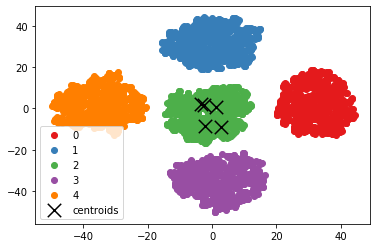

In [24]:
a,b = make_blobs(n_samples=4000,n_features=5, centers=5, cluster_std=0.7)
kmeans = KMeans(n_clusters=5, random_state=0).fit(a)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(a)
tsne = pd.DataFrame(tsne)
tsne['k'] = kmeans.labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1],
                color=cdict[cluster],
                label=cluster)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            marker='x',color='black',s=180,
            label='centroids')
plt.legend();

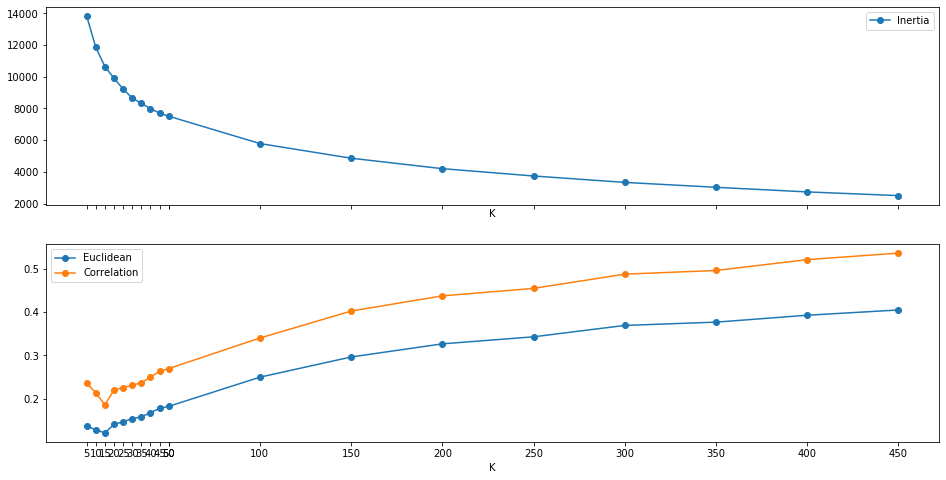

In [25]:
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_scaled)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_scaled,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_scaled,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5581 samples in 0.076s...
[t-SNE] Computed neighbors for 5581 samples in 1.691s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5581
[t-SNE] Computed conditional probabilities for sample 2000 / 5581
[t-SNE] Computed conditional probabilities for sample 3000 / 5581
[t-SNE] Computed conditional probabilities for sample 4000 / 5581
[t-SNE] Computed conditional probabilities for sample 5000 / 5581
[t-SNE] Computed conditional probabilities for sample 5581 / 5581
[t-SNE] Mean sigma: 0.461350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.722244
[t-SNE] KL divergence after 500 iterations: 1.004182


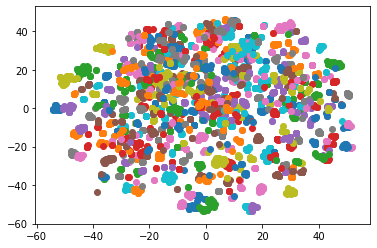

In [26]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(Xy_scaled)
tsne = pd.DataFrame(tsne)
tsne['k'] = results[400]['k'].labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1]
               )

In [28]:
xy = Xy_original.head()
xy

,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day
0,0,11,1,41,336,105,88,cellular,married,failure,Sv,may,0,1.0,11
1,0,26,1,56,192,229,1938,cellular,married,success,Tec,feb,2,3.0,26
2,0,8,2,30,-1,187,245,cellular,single,unknown,Sv,jul,2,0.0,8
3,0,17,1,34,-1,630,1396,cellular,single,unknown,Mg,jul,3,0.0,17
4,0,14,3,29,-1,512,-13,cellular,single,unknown,Tec,may,2,0.0,14


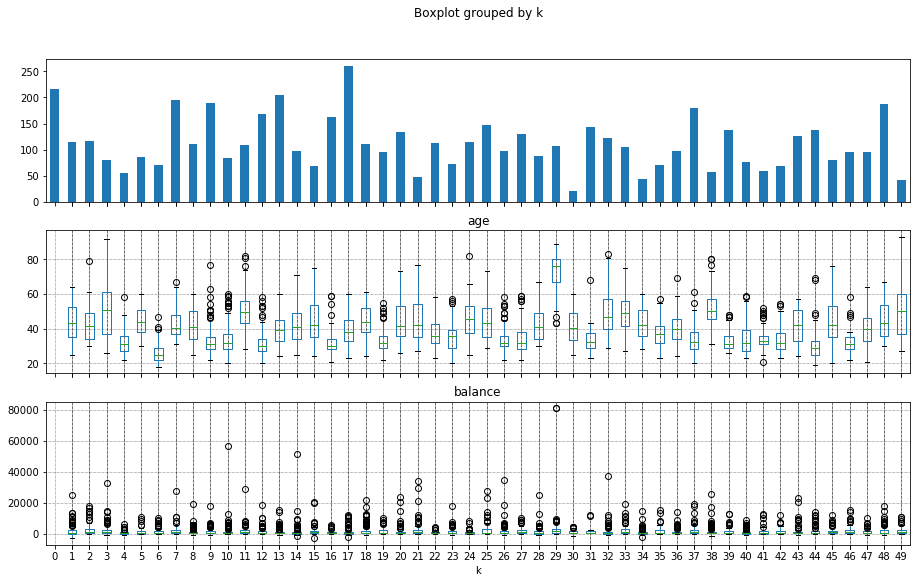

In [29]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=True)
Xy_original['k'] = results[50]['k'].labels_

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='age',ax=axs[1])
Xy_original.boxplot(by='k',column='balance',ax=axs[2])

#Remove contact marital poutcome job and month for the below code to work
#Xy_original.groupby('k').agg(["mean", "median", "var"])[:2]


In [32]:
Xy_original.drop(labels=['k'],axis=1,inplace=True)


In [34]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform

In [35]:
mhv = pdist(Xy_scaled, 'cityblock',)
mh = squareform(mhv,force='tomatrix')
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {mh.shape}")
pd.DataFrame(mh[:3,:3])

Data shape: (5581, 15)
Matrix shape: (5581, 5581)


,0,1,2
0,0.000000,8.347234,7.581081
1,8.347234,0.000000,10.199633
2,7.581081,10.199633,0.000000


Wall time: 15.4 s
Wall time: 29 s


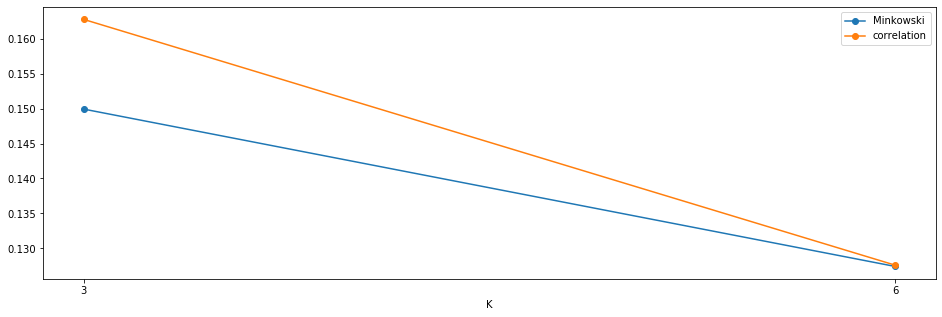

In [36]:
# find k clusters
results_kmedoids = dict()

k_cand = [3,6]

for k in k_cand:
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,1000,size=k)
    kmedoids_instance = kmedoids(mh,
                                 initial_medoids,
                                 data_type='distance_matrix')    

    # run cluster analysis and obtain results
    %time kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = silhouette_score(mh, cluster_array, metric='precomputed')
    score2 = silhouette_score(Xy_scaled, cluster_array,metric='correlation')
    
    # store
    results_kmedoids[k] = {'k':cluster_array,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results_kmedoids.keys()],[i['s1'] for i in results_kmedoids.values()],'o-',label='Minkowski')
axs.plot([i for i in results_kmedoids.keys()],[i['s2'] for i in results_kmedoids.values()],'o-',label='correlation')
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

In [43]:
# customised clarans using Manhattan distance
from cclarans import clarans
from pyclustering.utils import manhattan_distance,euclidean_distance_square

#manhattan_distance([1,1],[1,2]),euclidean_distance_square([1,1],[1,2])
#manhattan_distance(Xy_scaled_list[0],Xy_scaled_list[1])

Xy_scaled_list = Xy_scaled.to_numpy().tolist()
len(Xy_scaled_list)

clarans_instance = clarans(data=Xy_scaled_list,
                            number_clusters=10,
                            numlocal=1, 
                            maxneighbor=3)
#%time clarans_instance.process()
#clusters = clarans_instance.get_clusters()

Wall time: 1h 43min 43s


Wall time: 1min 19s


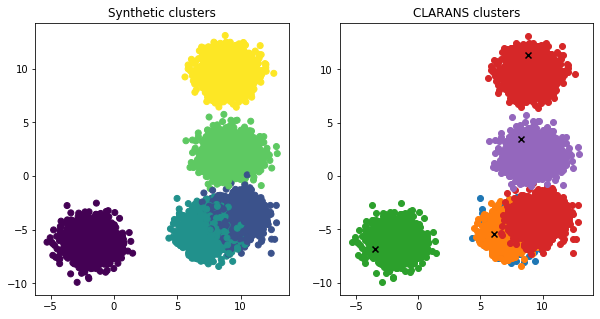

In [44]:
from pyclustering.cluster.clarans import clarans
from sklearn.datasets import make_blobs

# synthetic clusters
I,c = make_blobs(10302,n_features=36,centers=5)

# implement clarans
clarans_instance = clarans(I.tolist(), 5, 2, 4);
%time clarans_instance.process()
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(I[:,2],I[:,1],c=c)
axs[0].set_title('Synthetic clusters')
axs[1].set_title('CLARANS clusters')
for c_,m in zip(clusters,medoids):
    axs[1].scatter(I[c_,2],I[c_,1])
    axs[1].scatter(I[m,2],I[m,1],marker='x',c='black',label='medoids')

In [45]:
cat = [True if x in categorical_features else False for x in Xy_original.columns]

n = 5
focus = Xy_original.sample(1)
similar = gower.gower_topn(focus,Xy_original,
                           n=n,cat_features=cat)
focus

,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day
2567,0,26,4,41,-1,125,2085,unknown,married,unknown,Sv,may,2,0.0,26


In [46]:
print(similar['values'])
Xy_original.iloc[similar['index']]

[0.         0.00879452 0.0121997  0.01476661 0.01566176]


,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day
2567,0,26,4,41,-1,125,2085,unknown,married,unknown,Sv,may,2,0.0,26
1627,0,26,1,47,-1,136,2070,unknown,married,unknown,Sv,may,2,0.0,26
2318,0,26,1,35,-1,240,437,unknown,married,unknown,Sv,may,2,0.0,26
2472,0,27,1,38,-1,267,133,unknown,married,unknown,Sv,may,2,0.0,27
3442,0,28,2,39,-1,104,-971,unknown,married,unknown,Sv,may,2,0.0,28


In [47]:
# create list of cat_feature indicator
cat = [True if x in categorical_features else False for x in Xy_original.columns]

%time gd = gower.gower_matrix(Xy_original, cat_features=cat)

Wall time: 25 s


In [48]:
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {gd.shape}")
pd.DataFrame(gd[:3,:3])

Data shape: (5581, 15)
Matrix shape: (5581, 5581)


,0,1,2
0,0.000000,0.428704,0.385961
1,0.428704,0.000000,0.454976
2,0.385961,0.454976,0.000000


In [49]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [50]:
# condensed matrix
gdv = squareform(gd,force='tovector')

# output matrix has format [idx1, idx2, dist, sample_count]
Z = linkage(gdv,method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df[:2]

,id1,id2,dist,n
0,1923.0,2445.0,0.000799,2.0
1,788.0,5543.0,0.000916,2.0


Leaves = 64


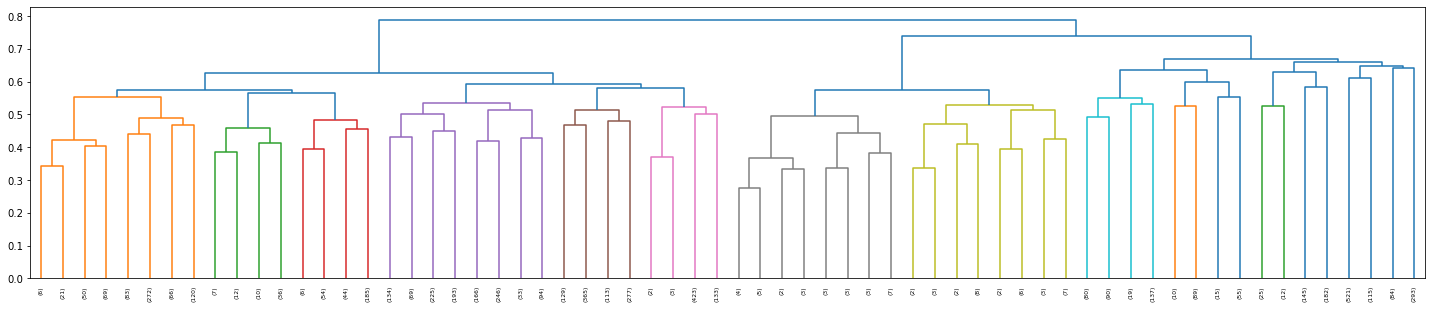

In [51]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=5,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

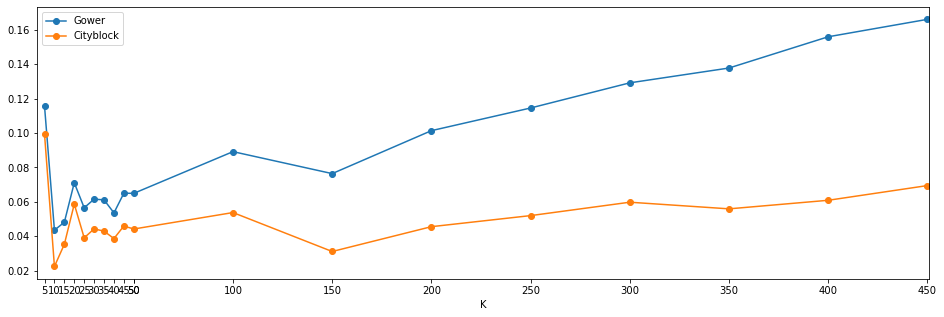

In [52]:
# find k clusters
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    cluster_array = fcluster(Z, k, criterion='maxclust')
    score0 = silhouette_score(gd, cluster_array, metric='precomputed')
    score1 = silhouette_score(Xy_scaled, cluster_array,metric='cityblock')
    results[k] = {'k':cluster_array,'s0':score0,'s1':score1}
    
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Gower')
axs.plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Cityblock')
axs.set_xlim(1,451)
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

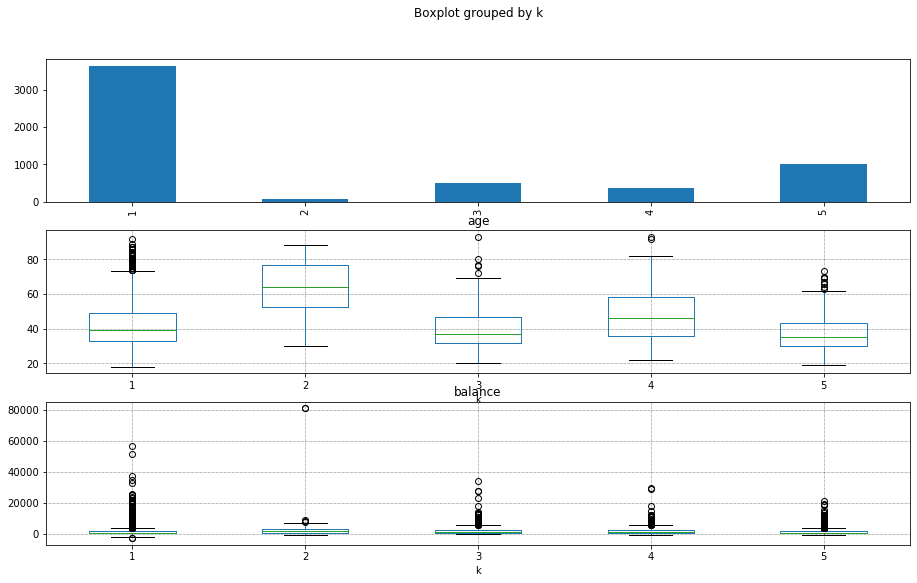

In [54]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=False)
Xy_original['k'] = results[5]['k']

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='age',ax=axs[1])
Xy_original.boxplot(by='k',column='balance',ax=axs[2])

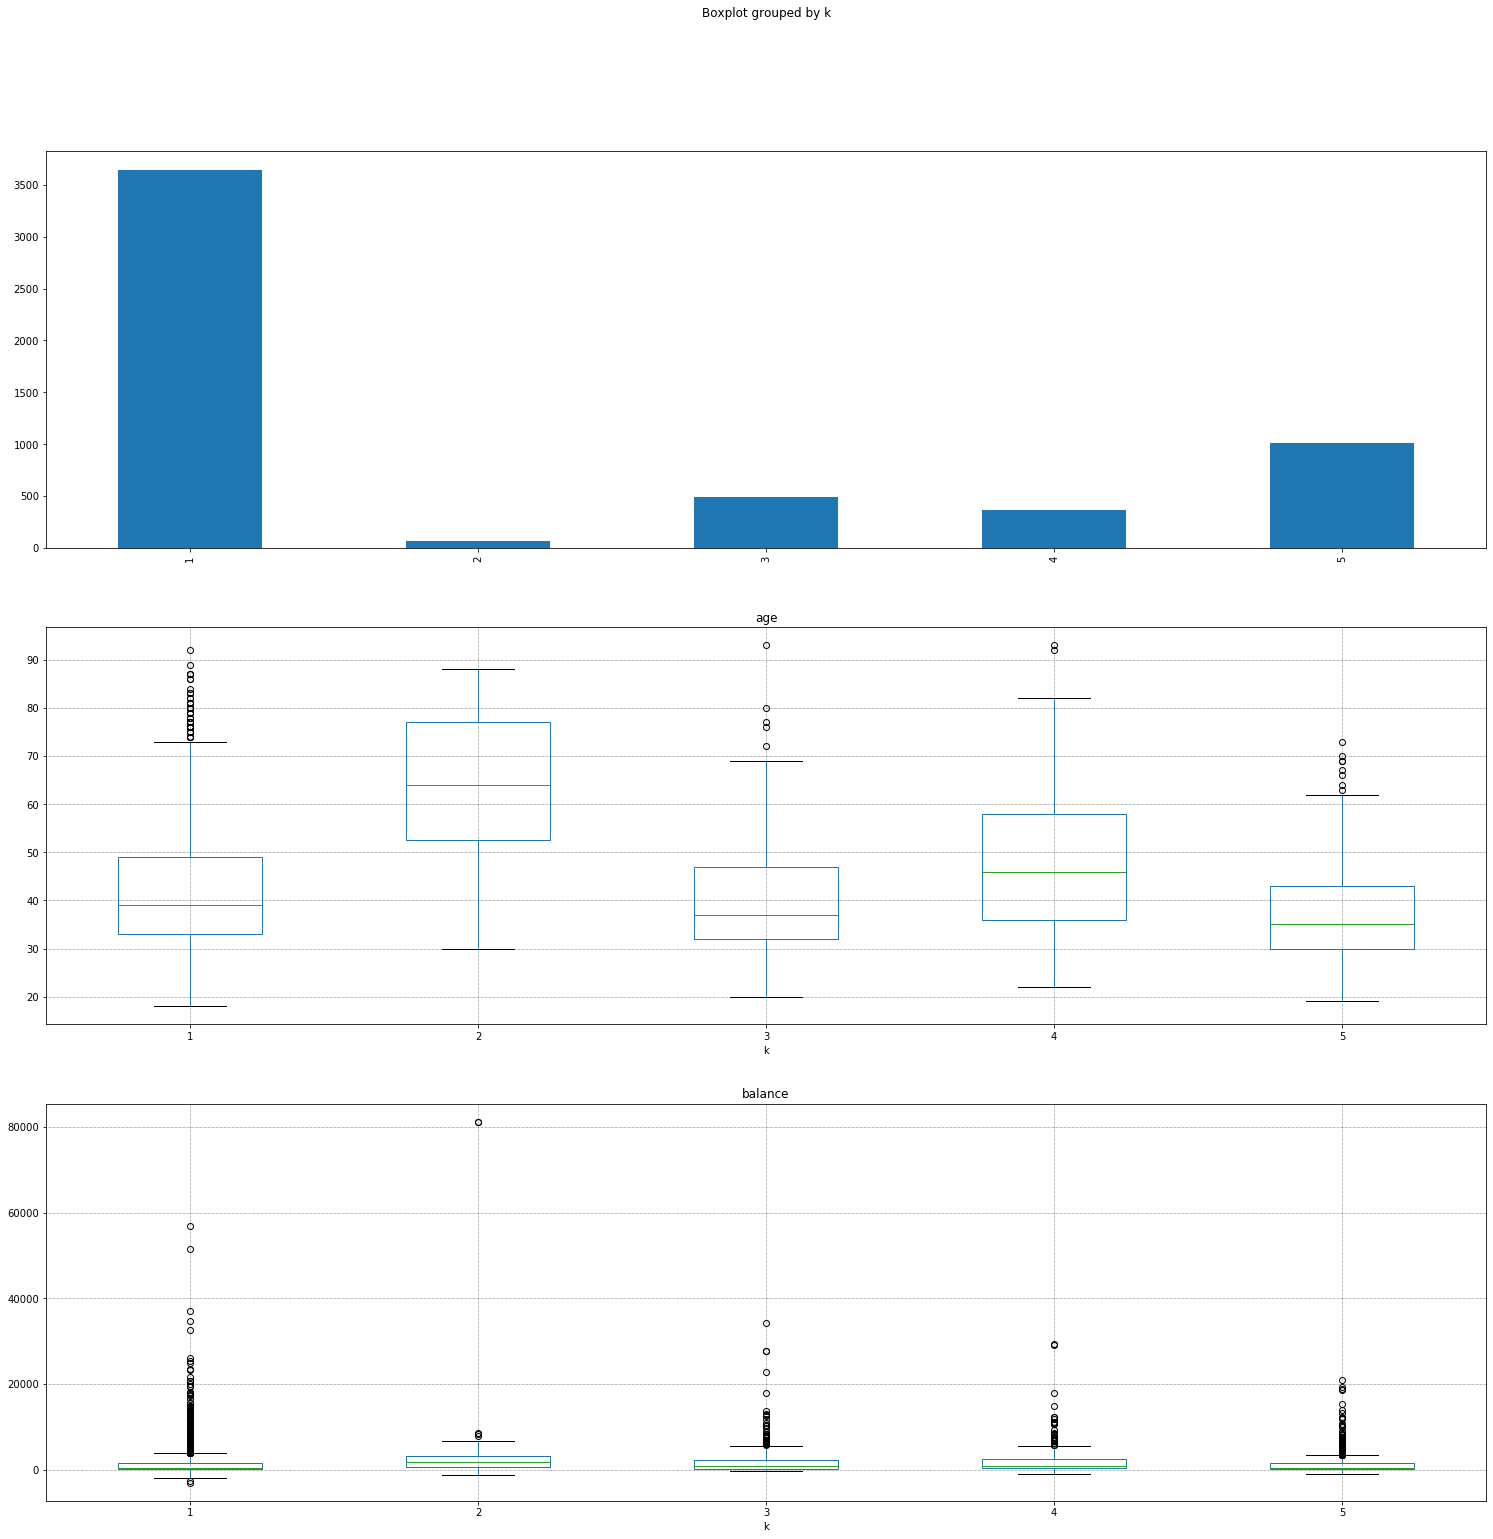

In [82]:

fig,axs = plt.subplots(3,1,figsize=(25,25),sharex=False)
Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='age',ax=axs[1])
Xy_original.boxplot(by='k',column='balance',ax=axs[2])


In [79]:
Xy_original

,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day,k
0,0,11,1,41,336,105,88,cellular,married,failure,Sv,may,0,1.0,11,5
1,0,26,1,56,192,229,1938,cellular,married,success,Tec,feb,2,3.0,26,4
2,0,8,2,30,-1,187,245,cellular,single,unknown,Sv,jul,2,0.0,8,5
3,0,17,1,34,-1,630,1396,cellular,single,unknown,Mg,jul,3,0.0,17,1
4,0,14,3,29,-1,512,-13,cellular,single,unknown,Tec,may,2,0.0,14,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5576,0,15,2,48,-1,755,2235,unknown,married,unknown,Ad,may,2,0.0,15,1
5577,0,4,3,40,340,195,-388,cellular,married,failure,Blu,may,1,0.0,4,5
5578,0,4,6,27,95,157,91,telephone,single,other,St,dec,2,8.0,4,5
5579,0,2,1,46,55,310,1568,cellular,married,other,Blu,jun,2,5.0,2,5
